In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

MODEL_NAME = 'gan_X'


In [2]:
!wget https://raw.githubusercontent.com/harsh2011/Numpys/master/TicTacToe.zip


Redirecting output to ‘wget-log’.


In [3]:
!unzip TicTacToe.zip

Archive:  TicTacToe.zip
  inflating: TicTacToe/O.npy         
  inflating: TicTacToe/X.npy         


In [17]:
x = np.load('TicTacToe/X.npy')
x.shape

(6963, 784)

In [18]:
x = x[150:6950]
x.shape

(6800, 784)

In [19]:
x0 = x[0]/255
x0

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [0]:
x = x/255

In [0]:
img_dim = 784
gen_dim = 512
disc_dim = 512
noise_dim = 100

In [0]:
input_node_name = 'noise_input_x'
output_node_name = 'gen_x'

gen_inp = tf.placeholder(tf.float32,shape=[None, noise_dim],name=input_node_name)
disc_inp = tf.placeholder(tf.float32,shape= [None, img_dim])

In [0]:
batch_size = 128
num_steps = 80000
learning_rate = 2e-4
display_step = 20

In [0]:
 def weight_init(shape):
        return tf.random_normal(shape=shape,stddev = 1./tf.sqrt(shape[0]/2.))

In [0]:
W = {"w1":tf.Variable(weight_init([noise_dim,gen_dim])),
    "w2":tf.Variable(weight_init([gen_dim,img_dim])),
    "w3":tf.Variable(weight_init([img_dim,disc_dim])),
    "w4":tf.Variable(weight_init([disc_dim,1]))}

b = {"b1":tf.Variable(tf.zeros([gen_dim])),
    "b2":tf.Variable(tf.zeros([img_dim])),
    "b3":tf.Variable(tf.zeros([disc_dim])),
    "b4":tf.Variable(tf.zeros([1]))}



In [0]:
def gen_fun(x,output_node_name):
    h1 = tf.matmul(x,W["w1"])
    h1 = tf.add(h1,b["b1"])
    h1 = tf.nn.relu(h1)
    
    h1 = tf.matmul(h1,W["w2"])
    h1 = tf.add(h1,b["b2"])
    h1 = tf.nn.sigmoid(h1, name=output_node_name)
    
    return h1


def disc_fun(x):
    h2 = tf.matmul(x,W["w3"])
    h2 = tf.add(h2,b["b3"])
    h2 = tf.nn.relu(h2)
    
    h2 = tf.matmul(h2,W["w4"])
    h2 = tf.add(h2,b["b4"])
    h2 = tf.nn.sigmoid(h2)
    
    return h2
    

In [0]:
gen_out = gen_fun(gen_inp,output_node_name)

disc_real_out = disc_fun(disc_inp)
disc_fake_out =  disc_fun(gen_out)

optim_gen = tf.train.AdamOptimizer(learning_rate = learning_rate)
optim_disc = tf.train.AdamOptimizer(learning_rate = learning_rate)

cost_gen = -tf.reduce_mean(tf.log(disc_fake_out))
cost_disc = -tf.reduce_mean(tf.log(disc_real_out)+tf.log(1.-disc_fake_out))

vars_gen = [W['w1'], W['w2'], b['b1'], b['b2']]
vars_disc = [W['w3'], W['w4'], b['b3'], b['b4']]

training_gen = optim_gen.minimize(cost_gen,var_list=vars_gen)
training_disc = optim_gen.minimize(cost_disc,var_list=vars_disc)


epoch 0: Generate Loss: 3.531116, Discriminator Loss: 0.174843
epoch 1: Generate Loss: 4.154960, Discriminator Loss: 0.047933
epoch 2: Generate Loss: 4.317398, Discriminator Loss: 0.049315
epoch 3: Generate Loss: 4.695019, Discriminator Loss: 0.027545
epoch 4: Generate Loss: 4.933044, Discriminator Loss: 0.030383
epoch 5: Generate Loss: 5.315444, Discriminator Loss: 0.013006
epoch 6: Generate Loss: 5.341263, Discriminator Loss: 0.013337
epoch 7: Generate Loss: 5.949040, Discriminator Loss: 0.018333
epoch 8: Generate Loss: 6.039913, Discriminator Loss: 0.009570
epoch 9: Generate Loss: 6.359828, Discriminator Loss: 0.004261
epoch 10: Generate Loss: 6.269085, Discriminator Loss: 0.005306
epoch 11: Generate Loss: 6.469138, Discriminator Loss: 0.002921
epoch 12: Generate Loss: 6.682178, Discriminator Loss: 0.002135
epoch 13: Generate Loss: 6.304120, Discriminator Loss: 0.003229
epoch 14: Generate Loss: 6.408170, Discriminator Loss: 0.005808
epoch 15: Generate Loss: 6.431352, Discriminator L

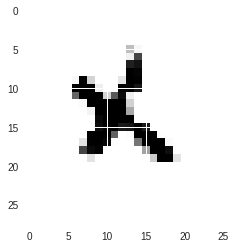

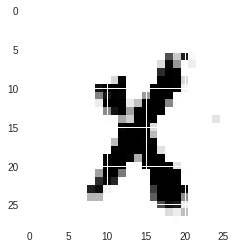

In [45]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
        
    saver = tf.train.Saver()

    tf.train.write_graph(sess.graph_def, 'out',
        MODEL_NAME + '.pbtxt', True)

    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter('logs/',
        graph=tf.get_default_graph())
    
    sess.run(init)
    
    for e in range(300):
    
        for step in range(0,x.shape[0],50):
                          
            batch_x = x[step:step+50]
            noise_temp = np.random.uniform(-1., 1., size=[50,noise_dim])

            feed_dict = {disc_inp: batch_x, gen_inp: noise_temp}

            _,dl = sess.run([training_disc, cost_disc],feed_dict = feed_dict)
            
            _,gl = sess.run([training_gen, cost_gen],feed_dict = feed_dict)


        print('epoch %i: Generate Loss: %f, Discriminator Loss: %f' %(e,gl,dl))
            
          
    saver.save(sess, 'out/' + MODEL_NAME + '.chkp')
    
    print("Finished !!")
    
    
    #n = 6 
    
    #canvas = np.empty((28*n,28*n))
    
    #for i in range(n):
        
    z = np.random.uniform(-1. , 1., size= [1, noise_dim])
        
    g = sess.run(gen_out, feed_dict = {gen_inp:z})
        
    g = -1*(g-1)
        
    #   for j in range(n):
    #       canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28,28])
            
    plt.imshow(g.reshape([28,28]),origin="upper",cmap="gray")
    plt.show()
    
    z = np.random.uniform(-1. , 1., size= [1, noise_dim])
        
    g = sess.run(gen_out, feed_dict = {gen_inp:z})
        
    g = -1*(g-1)
    plt.imshow(g.reshape([28,28]),origin="upper",cmap="gray")
    plt.show()
    

In [46]:
freeze_graph.freeze_graph('out/' + MODEL_NAME + '.pbtxt', None, False,
    'out/' + MODEL_NAME + '.chkp', output_node_name, "save/restore_all",
    "save/Const:0", 'out/frozen_' + MODEL_NAME + '.pb', True, "")

input_graph_def = tf.GraphDef()
with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
    input_graph_def.ParseFromString(f.read())

input_node_names = ['noise_input_x']
    
output_graph_def = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def, input_node_names, [output_node_name],
        tf.float32.as_datatype_enum)

with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
    f.write(output_graph_def.SerializeToString())

INFO:tensorflow:Restoring parameters from out/gan_O.chkp
INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.


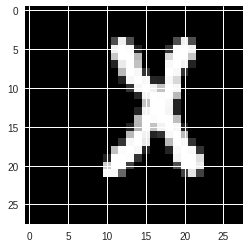

In [47]:
plt.imshow(x[100].reshape([28,28]),origin="upper",cmap="gray")
plt.show()

In [48]:
from google.colab import files
import os

for file in os.listdir("./out"):
  print(file)
  files.download('out/'+file)

gan_O.pbtxt
gan_O.chkp.meta
opt_gan_O.pb
gan_O.chkp.data-00000-of-00001
gan_O.chkp.index
frozen_gan_O.pb
checkpoint
